## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
#nltk.download('universal_tagset')

In [3]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [4]:
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

### Build the vanilla Viterbi based POS tagger

In [5]:
# Splitting into train and test
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('Still', 'ADV'), (',', '.'), ('scientists', 'NOUN'), ('breathed', 'VERB'), ('a', 'DET'), ('collective', 'ADJ'), ('sigh', 'NOUN'), ('of', 'ADP'), ('relief', 'NOUN'), ('about', 'ADP'), ('the', 'DET'), ('finding', 'NOUN'), (',', '.'), ('because', 'ADP'), ('it', 'PRON'), ('demonstrates', 'VERB'), ('how', 'ADV'), ('*', 'X'), ('to', 'PRT'), ('overcome', 'VERB'), ('the', 'DET'), ('``', '.'), ('flux', 'NOUN'), ('pinning', 'NOUN'), ("''", '.'), ('problem', 'NOUN'), ('that', 'ADP'), ('*T*-1', 'X'), ('earlier', 'ADV'), ('this', 'DET'), ('year', 'NOUN'), ('was', 'VERB'), ('widely', 'ADV'), ('publicized', 'VERB'), ('as', 'ADP'), ('*', 'X'), ('undercutting', 'VERB'), ('new', 'ADJ'), ('superconductors', 'NOUN'), ("'", 'PRT'), ('potential', 'NOUN'), ('*T*-2', 'X'), ('.', '.')], [('Faulding', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('it', 'PRON'), ('owns', 'VERB'), ('33', 'NUM'), ('%', 'NOUN'), ('of', 'ADP'), ('Moleculon', 'NOUN'), ("'s", 'PRT'), ('voting', 'NOUN'), ('stock', 'NOUN'), ('and'

In [6]:
# Getting list of tagged words for both Train and Test
train_tagged_words = [wrd for x in train_set for wrd in x]
print("Train Tagged Words - ", len(train_tagged_words))

Train Tagged Words -  96068


In [7]:
test_tagged_words = [wrd[0] for x in test_set for wrd in x]
print("Test Tagged Words - ", len(test_tagged_words))

Test Tagged Words -  4608


In [8]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Still',
 ',',
 'scientists',
 'breathed',
 'a',
 'collective',
 'sigh',
 'of',
 'relief',
 'about']

In [9]:
#POS tags in Train set
train_pos_tokens = [tag[1] for tag in train_tagged_words]
train_pos_tokens[:10]

['ADV', '.', 'NOUN', 'VERB', 'DET', 'ADJ', 'NOUN', 'ADP', 'NOUN', 'ADP']

In [10]:
# vocabulary
V = set(tokens)
print(len(V))

12132


In [11]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [12]:
print(T)

{'CONJ', '.', 'PRON', 'NUM', 'PRT', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'X', 'ADV'}


### Emission Probabilities

In [13]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [14]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probabilities

In [15]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [16]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [17]:
tags_matrix

array([[4.59347735e-04, 3.44510786e-02, 5.78778125e-02, 4.18006442e-02,
        5.05282497e-03, 1.57556266e-01, 1.21267803e-01, 3.49563628e-01,
        5.28249890e-02, 1.16214976e-01, 8.26825947e-03, 5.46623804e-02],
       [5.77920899e-02, 9.43818241e-02, 6.59330860e-02, 8.05152953e-02,
        2.41545890e-03, 8.89246762e-02, 1.73286811e-01, 2.22222224e-01,
        9.04455185e-02, 4.41044904e-02, 2.71068178e-02, 5.27822524e-02],
       [5.37634408e-03, 3.95545326e-02, 8.06451589e-03, 7.29646720e-03,
        1.19047621e-02, 4.86943156e-01, 9.98463947e-03, 2.06989244e-01,
        2.38095243e-02, 7.25806430e-02, 9.40860212e-02, 3.34101394e-02],
       [1.33412397e-02, 1.17106430e-01, 1.48235995e-03, 1.85887933e-01,
        2.69789509e-02, 1.86777357e-02, 3.26119177e-03, 3.51319313e-01,
        3.46872211e-02, 3.35013345e-02, 2.10791573e-01, 2.96471990e-03],
       [2.26537208e-03, 4.14239466e-02, 1.81229766e-02, 5.63106798e-02,
        1.94174761e-03, 4.01618123e-01, 1.02265373e-01, 2.47

In [18]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [19]:
tags_df

,CONJ,.,PRON,NUM,PRT,VERB,DET,NOUN,ADP,ADJ,X,ADV
CONJ,0.000459,0.034451,0.057878,0.041801,0.005053,0.157556,0.121268,0.349564,0.052825,0.116215,0.008268,0.054662
.,0.057792,0.094382,0.065933,0.080515,0.002415,0.088925,0.173287,0.222222,0.090446,0.044104,0.027107,0.052782
PRON,0.005376,0.039555,0.008065,0.007296,0.011905,0.486943,0.009985,0.206989,0.023810,0.072581,0.094086,0.033410
NUM,0.013341,0.117106,0.001482,0.185888,0.026979,0.018678,0.003261,0.351319,0.034687,0.033501,0.210792,0.002965
PRT,0.002265,0.041424,0.018123,0.056311,0.001942,0.401618,0.102265,0.247896,0.021036,0.083495,0.013592,0.010032
VERB,0.005414,0.034880,0.035499,0.022815,0.031168,0.168523,0.133256,0.111137,0.092343,0.064811,0.218407,0.081748
DET,0.000481,0.017666,0.003605,0.021512,0.000240,0.039659,0.005528,0.637904,0.009374,0.205504,0.045788,0.012739
NOUN,0.043177,0.240013,0.004826,0.009180,0.044302,0.146149,0.013316,0.264794,0.176082,0.012191,0.029172,0.016799
ADP,0.000852,0.038986,0.068279,0.062740,0.001385,0.008202,0.324776,0.322433,0.016937,0.106519,0.035045,0.013847
ADJ,0.017581,0.064246,0.000657,0.021525,0.011173,0.011502,0.004601,0.700460,0.076898,0.065725,0.020868,0.004765


In [20]:
tags_df.loc['.', :]

CONJ    0.057792
.       0.094382
PRON    0.065933
NUM     0.080515
PRT     0.002415
VERB    0.088925
DET     0.173287
NOUN    0.222222
ADP     0.090446
ADJ     0.044104
X       0.027107
ADV     0.052782
Name: ., dtype: float32

### EDA

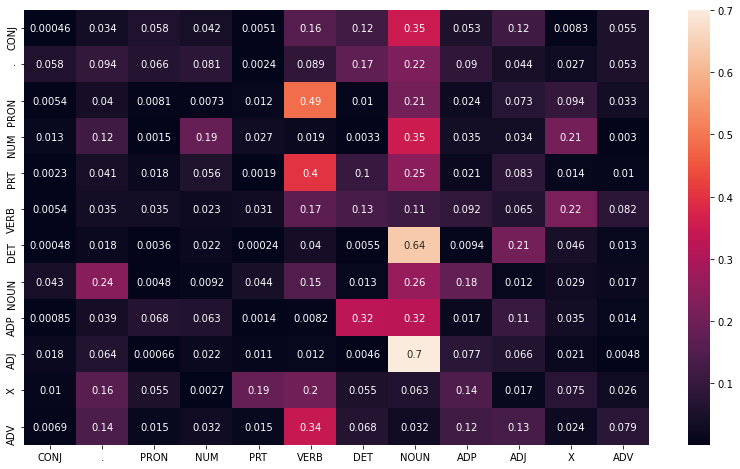

In [21]:
# Heatmap on the tags_df

plt.figure(figsize=(14, 8))
sns.heatmap(tags_df, annot = True)
plt.show()

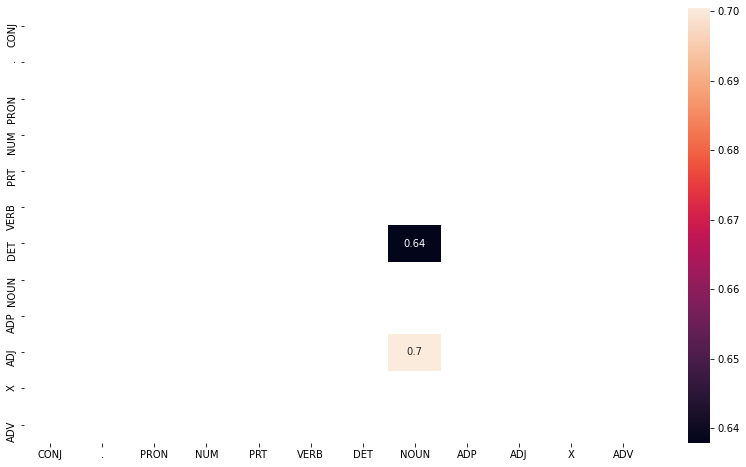

In [22]:
# filtering the df to get P(t2, t1) > 0.5

tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(14, 8))
sns.heatmap(tags_frequent, annot = True)
plt.show()

### Viterbi Algorithm

In [23]:
len(train_tagged_words)

96068

In [24]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Evaluation on Test set

In [25]:
#Testing the Alogorithm

rsents = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
algo_test = [test_set[i] for i in rsents]

# list of tagged words
algo_test_base = [tup for sent in algo_test for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in algo_test for tup in sent]
algo_test

[[('Vicar', 'NOUN'),
  ('Marshall', 'NOUN'),
  ('admits', 'VERB'),
  ('to', 'PRT'),
  ('mixed', 'VERB'),
  ('feelings', 'NOUN'),
  ('about', 'ADP'),
  ('this', 'DET'),
  ('issue', 'NOUN'),
  (',', '.'),
  ('since', 'ADP'),
  ('he', 'PRON'),
  ('is', 'VERB'),
  ('both', 'DET'),
  ('a', 'DET'),
  ('vicar', 'NOUN'),
  ('and', 'CONJ'),
  ('an', 'DET'),
  ('active', 'ADJ'),
  ('bell-ringer', 'NOUN'),
  ('himself', 'PRON'),
  ('.', '.')],
 [('The', 'DET'),
  ('board', 'NOUN'),
  ('already', 'ADV'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('searching', 'VERB'),
  ('for', 'ADP'),
  ('strong', 'ADJ'),
  ('outside', 'ADJ'),
  ('candidates', 'NOUN'),
  (',', '.'),
  ('including', 'VERB'),
  ('food-industry', 'NOUN'),
  ('executives', 'NOUN'),
  ('with', 'ADP'),
  ('considerable', 'ADJ'),
  ('international', 'ADJ'),
  ('experience', 'NOUN'),
  ('.', '.')],
 [('Now', 'ADV'),
  (',', '.'),
  ('13', 'NUM'),
  ('years', 'NOUN'),
  ('later', 'ADV'),
  (',', '.'),
  ('Mr.', 'NOUN'),
  ('Lane', 'NOUN'),

In [26]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [27]:
difference

26.663159132003784

In [28]:
# accuracy
check = [i for i, j in zip(tagged_seq, algo_test_base) if i == j] 

In [29]:
accuracy = len(check)/len(tagged_seq)

In [30]:
accuracy

0.9017857142857143

In [31]:
Accuracy_in_percentage = accuracy*100
print('The Accuracy of Viterbi Algorithm is : ',Accuracy_in_percentage)

The Accuracy of Viterbi Algorithm is :  90.17857142857143


In [32]:
incorrect_tagged_cases = [[algo_test_base[i-1],j] for i, j in enumerate(zip(tagged_seq, algo_test_base)) if j[0]!=j[1]]

In [33]:
incorrect_tagged_cases

[[('.', '.'), (('Vicar', 'CONJ'), ('Vicar', 'NOUN'))],
 [('mixed', 'VERB'), (('feelings', 'CONJ'), ('feelings', 'NOUN'))],
 [('active', 'ADJ'), (('bell-ringer', 'CONJ'), ('bell-ringer', 'NOUN'))],
 [('been', 'VERB'), (('searching', 'CONJ'), ('searching', 'VERB'))],
 [('including', 'VERB'),
  (('food-industry', 'CONJ'), ('food-industry', 'NOUN'))],
 [('years', 'NOUN'), (('later', 'ADJ'), ('later', 'ADV'))],
 [('a', 'DET'), (('full-length', 'CONJ'), ('full-length', 'ADJ'))],
 [('a', 'DET'), (('poignant', 'CONJ'), ('poignant', 'ADJ'))],
 [('a', 'DET'), (('modern-day', 'CONJ'), ('modern-day', 'ADJ'))],
 [('modern-day', 'ADJ'), (('tramp', 'CONJ'), ('tramp', 'NOUN'))],
 [('the', 'DET'), (('most', 'ADJ'), ('most', 'ADV'))]]

### Unknown Words

In [36]:
#unknown words
v_Test = set([t for t in test_tagged_words])
unknown_words = list(v_Test - V)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :", unknown_words)

Total Unknown words : 9


Unknown Words : ['poignant', 'full-length', 'bell-ringer', 'Vicar', 'food-industry', 'feelings', 'searching', 'modern-day', 'tramp']


### Solve the problem of unknown words

In [37]:
# Unigram tagger
unigram_tagger = nltk.UnigramTagger(train_set)
accuracy_unigram_tagger = unigram_tagger.evaluate(test_set)
print(accuracy_unigram_tagger)

0.9127604166666666


In [39]:
# patterns for tagging using a rule based regex tagger -

patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),                         # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),                                  # possessive nouns
    (r'.*s$', 'NOUN'),                                    # plural nouns
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'),                            # Any special character combination
    (r'.*ould$', 'X'),                                    # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'),                                  # adjective like 100-megabytes 237-Seats
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'),                    # Any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')                        # Numbers 
    ]

In [40]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

accuracy_lexicon_tagger = lexicon_tagger.evaluate(test_set)
print(accuracy_lexicon_tagger)

0.9392361111111112


In [41]:
# Bigram and Trigram tagger
bigram_tagger = nltk.BigramTagger(train_set,backoff=lexicon_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print(accuracy_bigram_tagger)

0.9405381944444444


In [42]:
trigram_tagger = nltk.TrigramTagger(train_set, backoff=bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print(accuracy_trigram_tagger)

0.9405381944444444


#### Bigram Tagger gives a slightly better accuracy than Trigram tagger, however any of the Bigram or Trigram gives me better accuracy than Viterbi Heuristic Algorithm. 

#### Method 1

#### Now, we will build this into Veterbi algorithm. We need to change the regex to fit to our data.

In [43]:
# A trigram tagger backed off by a rule based tagger.

def trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [44]:
# viterbi with handling for unknown words from regex tagger

def new_Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # unknown words from trigram taggr
        if word not in V:
            unk_word_tag=trigram_tagger(word)
            for sent in unk_word_tag:
                for tup in sent:
                    state.append(tup[1])
        # rest remains same            
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))

In [45]:
start = time.time()
tagged_seq = new_Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, algo_test_base) if i == j] 
viterbi_trigram_accuracy = len(check)/len(tagged_seq)
print('Vanilla Viterbi for Unknown Words Accuracy: ',viterbi_trigram_accuracy*100)

Time taken in seconds:  55.856895208358765
Vanilla Viterbi for Unknown Words Accuracy:  95.53571428571429


### Method 2

In [46]:
#creating a list  of POS tags and POS tag occurance probability, based on training data

tag_prob = []
total_tag = len([tag for word,tag in train_tagged_words])
for t in T:
    each_tag = [tag for word,tag in train_tagged_words if tag==t]
    tag_prob.append((t,len(each_tag)/total_tag))

tag_prob

[('CONJ', 0.02266103176916351),
 ('.', 0.11635508181704626),
 ('PRON', 0.027105800058292044),
 ('NUM', 0.03511054669609027),
 ('PRT', 0.032164716659033185),
 ('VERB', 0.13459216388391557),
 ('DET', 0.08661573052421202),
 ('NOUN', 0.2868905358704251),
 ('ADP', 0.09772244660032477),
 ('ADJ', 0.06335095973685306),
 ('X', 0.06591164591747513),
 ('ADV', 0.03151934046716909)]

In [47]:
# use transition probability of tags when emission probability is zero (in case of unknown words)

def Vanilla_Viterbi_for_Unknown_Words(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
       
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p             
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use weighted transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]                 
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [48]:
# tagging the test sentences
start = time.time()
tagged_seq = Vanilla_Viterbi_for_Unknown_Words(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
viterbi_word_check = [i for i, j in zip(tagged_seq, algo_test_base) if i == j] 
accuracy_viterbi_modified = len(viterbi_word_check)/len(tagged_seq) * 100
print('Modified Vanilla Viterbi for Unknown Words Accuracy: ', accuracy_viterbi_modified)

Time taken in seconds:  27.88838291168213
Modified Vanilla Viterbi for Unknown Words Accuracy:  94.64285714285714


#### Method 1 or Using a Trigram Tagger Regex Pattern gives better Accuracy.

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [49]:
data_Accuracy = [['Vanilla Viterbi', accuracy*100], 
                  ['Vanilla Viterbi Modified', accuracy_viterbi_modified], 
                  ['Unigram Tagger', accuracy_unigram_tagger * 100],
                  ['Unigram + RegexTagger', accuracy_lexicon_tagger * 100],
                  ['Bigram Tagger + Unigram_tagger', accuracy_bigram_tagger*100],
                  ['Trigram Tagger + Bigram_tagger', accuracy_trigram_tagger*100],
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy*100]]


In [50]:
df = pd.DataFrame(data_Accuracy, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

In [51]:
df.set_index('Tagging_Algorithm', drop = True, inplace = True)

df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,90.178571
Vanilla Viterbi Modified,94.642857
Unigram Tagger,91.276042
Unigram + RegexTagger,93.923611
Bigram Tagger + Unigram_tagger,94.053819
Trigram Tagger + Bigram_tagger,94.053819
Viterbi + Trigram_tagger,95.535714


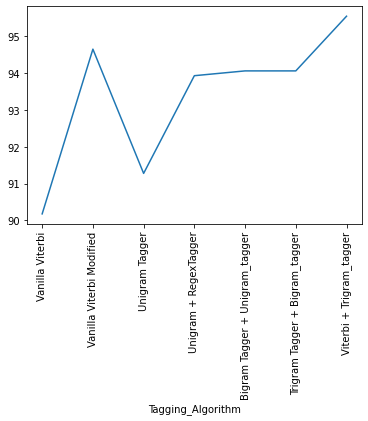

In [52]:
#Plotting the Model accuracies

df.plot.line(rot = 90, legend = False)
plt.show()

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [63]:
## Testing 1
sentence_test = 'Twitter is the best networking social site. Man is a social animal.'
words = word_tokenize(sentence_test)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('Twitter', 'CONJ'), ('is', 'VERB'), ('the', 'DET'), ('best', 'ADJ'), ('networking', 'NOUN'), ('social', 'ADJ'), ('site', 'CONJ'), ('.', '.'), ('Man', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('social', 'ADJ'), ('animal', 'CONJ'), ('.', '.')]


In [64]:
tagged_seq_modified = new_Viterbi(words)
print(tagged_seq_modified)

[('Twitter', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('best', 'ADJ'), ('networking', 'NOUN'), ('social', 'ADJ'), ('site', 'NOUN'), ('.', '.'), ('Man', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('social', 'ADJ'), ('animal', 'NOUN'), ('.', '.')]


In [61]:
#Testing 2

sentence_test_2 = 'Google and Twitter made a deal in 2015 that gave Google access to Twitter\'s firehose.'
words2 = word_tokenize(sentence_test_2)
tagged_seq2 = Viterbi(words2)
print(tagged_seq2)

[('Google', 'CONJ'), ('and', 'CONJ'), ('Twitter', 'CONJ'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'CONJ'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'CONJ'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'CONJ'), ("'s", 'VERB'), ('firehose', 'CONJ'), ('.', '.')]


In [62]:
tagged_seq_modified_2 = new_Viterbi(words2)
print(tagged_seq_modified_2)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


In [65]:
#Testing 3

sentence_test_3 = 'Data science is an emerging field. Data science jobs are high in demand.'
words3 = word_tokenize(sentence_test_3)
tagged_seq3 = Viterbi(words3)
print(tagged_seq3)

[('Data', 'NOUN'), ('science', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('emerging', 'VERB'), ('field', 'NOUN'), ('.', '.'), ('Data', 'NOUN'), ('science', 'NOUN'), ('jobs', 'NOUN'), ('are', 'VERB'), ('high', 'ADJ'), ('in', 'ADP'), ('demand', 'NOUN'), ('.', '.')]


In [66]:
tagged_seq_modified_3 = new_Viterbi(words3)
print(tagged_seq_modified_3)

[('Data', 'NOUN'), ('science', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('emerging', 'VERB'), ('field', 'NOUN'), ('.', '.'), ('Data', 'NOUN'), ('science', 'NOUN'), ('jobs', 'NOUN'), ('are', 'VERB'), ('high', 'ADJ'), ('in', 'ADP'), ('demand', 'NOUN'), ('.', '.')]


#### In the First 2 Tests, we can see for example `Twitter` ,  `Google` and a few more got incorrectly tagged in the initial Virerbi Model but got corrected when we used the `new_Viterbi` model or the  `Trigram Viterbi modified`  model. 

#### The third test however got correctly tagged on both the models which when given the accuracy says  `initial Viterbi had 90% accuracy`  makes sense. 